In [48]:
def get_exploration_path():
    return "ParlaMint/Samples/ParlaMint-BA/"

In [49]:
from pathlib import Path

def get_countries(data_folder="ParlaMint"):
    data_path = Path(data_folder)
    xml_en_files = []
    for country_dir in (data_path / "Samples").iterdir():
        if country_dir.is_dir():
            country_code = country_dir.name.replace("ParlaMint-", "")
            xml_en_files.extend(list(country_dir.rglob("*-en_*.ana.xml")))
    return xml_en_files

In [50]:
from lxml import etree
import pandas as pd 

NS = {"tei": "http://www.tei-c.org/ns/1.0"}

def parse_parlamint_xml(xml_path):
    tree = etree.parse(str(xml_path))
    root = tree.getroot()

    date_str = root.xpath(".//tei:settingDesc/tei:setting/tei:date/@when", namespaces=NS)
    speech_date = pd.to_datetime(date_str[0]) if date_str else None

    data = []
    utterances = root.xpath("//tei:u", namespaces=NS)

    for u in utterances:
        u_id = u.get("{http://www.w3.org/XML/1998/namespace}id")
        speaker = u.get("who")
        ana = u.get("ana", "")
        topics = [a.replace("topic:", "") for a in ana.split() if "topic:" in a]

        sentences = u.xpath(".//tei:s", namespaces=NS)
        for s in sentences:
            s_id = s.get("{http://www.w3.org/XML/1998/namespace}id")
            
            sentiment_node = s.xpath(".//tei:measure[@type='sentiment']", namespaces=NS)
            sentiment_score = float(sentiment_node[0].get("quantity")) if sentiment_node else None
            
            named_entities = s.xpath(".//tei:name/@type", namespaces=NS)
            
            tokens = []
            reconstructed_text = ""
            
            token_elements = s.xpath(".//tei:w | .//tei:pc", namespaces=NS)
            
            for i, token_el in enumerate(token_elements):
                token_text = token_el.text or ""
                
                token_data = {
                    "text": token_text,
                    "type": "word" if token_el.tag.endswith("w") else "punct",
                    "lemma": token_el.get("lemma"),
                    "pos": token_el.get("pos"),
                    "msd": token_el.get("msd"),
                    "sem": token_el.get("function")
                }
                tokens.append(token_data)
                
                reconstructed_text += token_text
                if token_el.get("join") != "right" and i < len(token_elements) - 1:
                    reconstructed_text += " "

            data.append({
                "u_id": u_id,
                "s_id": s_id,
                "speaker": speaker,
                "topics": topics,
                "sentiment": sentiment_score,
                "entities": list(set(named_entities)),
                "text": reconstructed_text,
                "tokens": tokens, 
                "date": speech_date,
                "sentence_length": len(tokens)
            })
            
    return data

In [51]:
def load_taxonomy(taxonomy_path):
    tree = etree.parse(str(taxonomy_path))
    categories = tree.xpath("//tei:category", namespaces=NS)
    mapping = {}
    for cat in categories:
        cat_id = cat.get("{http://www.w3.org/XML/1998/namespace}id")
        full_desc = cat.xpath("string(./tei:catDesc)", namespaces=NS)
        if cat_id and full_desc:
            if ":" in full_desc:
                mapping[cat_id] = full_desc.split(":", 1)[-1].strip()
            else:
                mapping[cat_id] = full_desc.strip()
    return mapping

In [52]:
def load_person_list(person_path):
    tree = etree.parse(str(person_path))
    root = tree.getroot()
    
    persons = root.xpath("//tei:person", namespaces=NS)
    person_mapping = {}
    
    for p in persons:
        p_id = p.get("{http://www.w3.org/XML/1998/namespace}id")
        
        # Get full name
        forenames = p.xpath(".//tei:persName/tei:forename/text()", namespaces=NS)
        surname = p.xpath(".//tei:persName/tei:surname/text()", namespaces=NS)
        full_name = f"{' '.join(forenames)} {''.join(surname)}".strip()
        
        # Get sex
        sex = p.xpath("./tei:sex/@value", namespaces=NS)
        sex = sex[0] if sex else None
        
        # Get current/last party affiliation
        affiliations = p.xpath(".//tei:affiliation[contains(@ref, '#')]", namespaces=NS)

        # Create a list of (party_ref, start_date, end_date) tuples
        party_info = []
        for aff in affiliations:
            party_ref = aff.get("ref").replace("#", "")
            if party_ref == 'PS':
                continue
            start_date = aff.get("from")
            end_date = aff.get("to")
            party_info.append((party_ref, start_date, end_date))

        person_mapping[f"#{p_id}"] = {
            "name": full_name,
            "sex": sex,
            "party_info": party_info
        }
        
    return person_mapping

person_path = str(get_exploration_path()) + "ParlaMint-BA-listPerson.xml"
speaker_info = load_person_list(person_path)

example_id = "#LjubičićDrago"
print(f"Info for {example_id}: {speaker_info.get(example_id)}")

Info for #LjubičićDrago: {'name': 'Drago Ljubičić', 'sex': 'M', 'party_info': [('party.SNS', '1998-11-26', '2000-10-23'), ('party.SNSD', '2006-11-20', '2010-09-01')]}


In [53]:
def load_org_list(org_path):
    tree = etree.parse(str(org_path))
    root = tree.getroot()
    
    orgs = root.xpath("//tei:org", namespaces=NS)
    org_mapping = {}
    
    for org in orgs:
        org_id = org.get("{http://www.w3.org/XML/1998/namespace}id")
        role = org.get("role")
        
        full_name = org.xpath("./tei:orgName[@full='yes']/text()", namespaces=NS)
        full_name = full_name[0] if full_name else None
        
        if not full_name:
            any_name = org.xpath("./tei:orgName/text()", namespaces=NS)
            full_name = any_name[0] if any_name else None
            
        org_mapping[org_id] = {
            "name": full_name.strip() if full_name else None,
            "role": role
        }
        
    return org_mapping

org_path = str(get_exploration_path()) + "ParlaMint-BA-listOrg.xml"
org_info = load_org_list(org_path)

print(f"Info for 'party.DNZ_BIH': {org_info.get('party.DNZ_BIH')}")

Info for 'party.DNZ_BIH': {'name': 'Demokratska narodna zajednica BiH', 'role': 'parliamentaryGroup'}


In [54]:
def get_topic_taxonomy(country_code, data_path="ParlaMint"):
    path = data_path / "Samples" / f"ParlaMint-{country_code}"
    topic_tax_path = path / "ParlaMint-taxonomy-topic.xml"
    return load_taxonomy(topic_tax_path)

def get_speaker_taxonomy(country_code, data_path="ParlaMint"):
    path = data_path / "Samples" / f"ParlaMint-{country_code}"
    topic_tax_path = path / "ParlaMint-taxonomy-politicalOrientation.xml"
    return load_taxonomy(topic_tax_path)

def get_ches_taxonomy(country_code, data_path="ParlaMint"):
    path = data_path / "Samples" / f"ParlaMint-{country_code}"
    topic_tax_path = path / "ParlaMint-taxonomy-CHES.xml"
    return load_taxonomy(topic_tax_path)

def get_named_entity_taxonomy(country_code, data_path="ParlaMint"):
    path = data_path / "Samples" / f"ParlaMint-{country_code}"
    topic_tax_path = path / "ParlaMint-taxonomy-NER.ana.xml"
    return load_taxonomy(topic_tax_path)

def get_sentiment_taxonomy(country_code, data_path="ParlaMint"):
    path = data_path / "Samples" / f"ParlaMint-{country_code}"
    topic_tax_path = path / "ParlaMint-taxonomy-sentiment.ana.xml"
    return load_taxonomy(topic_tax_path)

def get_speaker_type_taxonomy(country_code, data_path="ParlaMint"):
    path = data_path / "Samples" / f"ParlaMint-{country_code}"
    topic_tax_path = path / "ParlaMint-taxonomy-speaker_types.xml"
    return load_taxonomy(topic_tax_path)

In [55]:
def get_party_at_time(row, speaker_info):
    speaker = row['speaker']
    speech_date = row['date']
    
    speaker_data = speaker_info.get(speaker, {})
    affiliations = speaker_data.get('party_info', [])
    
    if not affiliations or affiliations == 'Unknown':
        return 'Unknown'
    
    for party_name, date_from, date_to in affiliations:
        start = pd.to_datetime(date_from) if date_from else pd.to_datetime('1950-01-01')
        end = pd.to_datetime(date_to) if date_to else pd.to_datetime('2030-12-31')
        
        if start <= speech_date <= end:
            return party_name
            
    return speaker_data.get('party', 'Unknown')

In [56]:
# --- Helper Functions ---

def extract_country_code(file_path):
    """(Private) Extracts country code from file path structure."""
    parts = str(file_path).split('/')
    return next((p.replace('ParlaMint-', '') for p in parts if p.startswith('ParlaMint-')), 'Unknown')

def load_country_resources(country_code, data_path):
    """
    (Private) Loads all taxonomy and metadata resources for a specific country.
    Returns: (topic_map, speaker_info, org_info) or (None, None, None) if missing.
    """
    country_dir = data_path / "Samples" / f"ParlaMint-{country_code}"
    person_path = country_dir / f"ParlaMint-{country_code}-listPerson.xml"
    org_path = country_dir / f"ParlaMint-{country_code}-listOrg.xml"
    
    if not person_path.exists() or not org_path.exists():
        return None, None, None

    # Load Resources
    s_info = load_person_list(person_path)
    o_info = load_org_list(org_path)
    
    try:
        # data_path here is the root "ParlaMint" Folder
        t_map = get_topic_taxonomy(country_code, data_path) 
    except Exception:
        t_map = {}
        
    return t_map, s_info, o_info

def enrich_dataframe(df, data_path):
    """(Private) Enriches the dataframe with metadata by country."""
    unique_countries = df['country_code'].dropna().unique()
    
    # Pre-initialize columns
    new_cols = ['speaker_name', 'speaker_sex', 'party_id', 'party_name', 'topic_labels']
    for col in new_cols:
        df[col] = 'Unknown'
    df['topic_labels'] = df['topic_labels'].apply(lambda x: [])

    for country in unique_countries:
        if country == 'Unknown': continue

        # Load resources once per country
        topic_map, s_info, o_info = load_country_resources(country, data_path)
        if not s_info: continue

        mask = df['country_code'] == country
        subset = df[mask]

        # 1. Speaker Types (Dict Lookups are fast)
        df.loc[mask, 'speaker_name'] = subset['speaker'].map(
            lambda x: s_info.get(x, {}).get('name', 'Unknown')
        )
        df.loc[mask, 'speaker_sex'] = subset['speaker'].map(
            lambda x: s_info.get(x, {}).get('sex', 'Unknown')
        )

        # 2. Temporal Party Logic
        df.loc[mask, 'party_id'] = subset.apply(
            lambda row: get_party_at_time(row, s_info), axis=1
        )

        # 3. Party Names
        df.loc[mask, 'party_name'] = df.loc[mask, 'party_id'].map(
            lambda x: o_info.get(x, {}).get('name', 'Unknown')
        )

        # 4. Topics
        if topic_map:
            df.loc[mask, 'topic_labels'] = subset['topics'].map(
                lambda t_list: [topic_map.get(t, t) for t in t_list] if t_list else []
            )
        else:
             df.loc[mask, 'topic_labels'] = subset['topics']
             
    return df

def get_full_dataframe(data_folder="ParlaMint"):
    """
    Main pipeline function to load, parse, and enrich ParlaMint data.
    """
    data_path = Path(data_folder)
    if not data_path.exists():
        raise FileNotFoundError(f"Data folder {data_folder} not found.")

    # 1. Discovery
    xml_files = get_countries(data_folder)
    print(f"Found {len(xml_files)} XML files. Parsing...")

    # 2. Parsing loop (Optimized: Inject country code immediately)
    all_records = []
    for f in xml_files:
        country_code = extract_country_code(f)
        file_data = parse_parlamint_xml(f)
        
        # Inject country code into records before creating DF
        # This avoids complex mapping logic later
        for record in file_data:
            record['country_code'] = country_code
            
        all_records.extend(file_data)

    if not all_records:
        return pd.DataFrame()

    df = pd.DataFrame(all_records)

    # 3. Enrichment
    print("Enriching data with metadata...")
    df = enrich_dataframe(df, data_path)

    print("Dataframe construction complete.")
    return df

final_df = get_full_dataframe()
final_df.head()

Found 87 XML files. Parsing...
Enriching data with metadata...
Dataframe construction complete.


,u_id,s_id,speaker,topics,sentiment,entities,text,tokens,date,sentence_length,country_code,speaker_name,speaker_sex,party_id,party_name,topic_labels
0,i-BQ8dtftkuwhpor9i8CsgBV,i-7Gocwwgm1SAsUELPMWzXuE,#Q4980750,[mixed],4.017,[],"Madam President, I would like","[{'text': 'Madam', 'type': 'word', 'lemma': 'm...",2022-05-13,6,SE,Annika Strandhäll,F,Q105112,Socialdemokraterna,[Mix]
1,i-BQ8dtftkuwhpor9i8CsgBV,i-7GodASKwaGTGUA8Kq8nQCL,#Q4980750,[mixed],2.313,"[PER, LOC]",Anders Åkesson has asked me when and in what w...,"[{'text': 'Anders', 'type': 'word', 'lemma': '...",2022-05-13,38,SE,Annika Strandhäll,F,Q105112,Socialdemokraterna,[Mix]
2,i-BQ8dtftkuwhpor9i8CsgBV,i-7GodHw7T7ZphsKCgv74KaC,#Q4980750,[mixed],2.331,[ORG],The County Administrative Board of Kalmar Coun...,"[{'text': 'The', 'type': 'word', 'lemma': 'the...",2022-05-13,23,SE,Annika Strandhäll,F,Q105112,Socialdemokraterna,[Mix]
3,i-BQ8dtftkuwhpor9i8CsgBV,i-7GodPmH4ygtVQDNXYCAFye,#Q4980750,[mixed],0.572,[],The proposals are aimed at removing the protec...,"[{'text': 'The', 'type': 'word', 'lemma': 'the...",2022-05-13,15,SE,Annika Strandhäll,F,Q105112,Socialdemokraterna,[Mix]
4,i-BQ8dtftkuwhpor9i8CsgBV,i-7GodVbSgqoxGw7YNAHGCP6,#Q4980750,[mixed],1.452,[ORG],As the matter is still being prepared in the G...,"[{'text': 'As', 'type': 'word', 'lemma': 'as',...",2022-05-13,34,SE,Annika Strandhäll,F,Q105112,Socialdemokraterna,[Mix]


# Dataset Overview

In [57]:
# Number of sentences per country
countries = final_df['country_code'].unique()

for country in countries:
    count = final_df[final_df['country_code'] == country].shape[0]
    print(f"Country: {country}, Number of Sentences: {count}")

Country: SE, Number of Sentences: 602
Country: UA, Number of Sentences: 365
Country: PL, Number of Sentences: 177
Country: BE, Number of Sentences: 100
Country: GR, Number of Sentences: 127
Country: NO, Number of Sentences: 57
Country: EE, Number of Sentences: 115
Country: LV, Number of Sentences: 110
Country: CZ, Number of Sentences: 644
Country: IS, Number of Sentences: 266
Country: IT, Number of Sentences: 69
Country: RS, Number of Sentences: 289
Country: SI, Number of Sentences: 137
Country: PT, Number of Sentences: 71
Country: ES-GA, Number of Sentences: 75
Country: GB, Number of Sentences: 198
Country: BA, Number of Sentences: 154
Country: ES-PV, Number of Sentences: 138
Country: AT, Number of Sentences: 65
Country: DK, Number of Sentences: 99
Country: BG, Number of Sentences: 192
Country: HU, Number of Sentences: 274
Country: NL, Number of Sentences: 94
Country: HR, Number of Sentences: 97
Country: FR, Number of Sentences: 113
Country: ES, Number of Sentences: 48
Country: FI, Nu

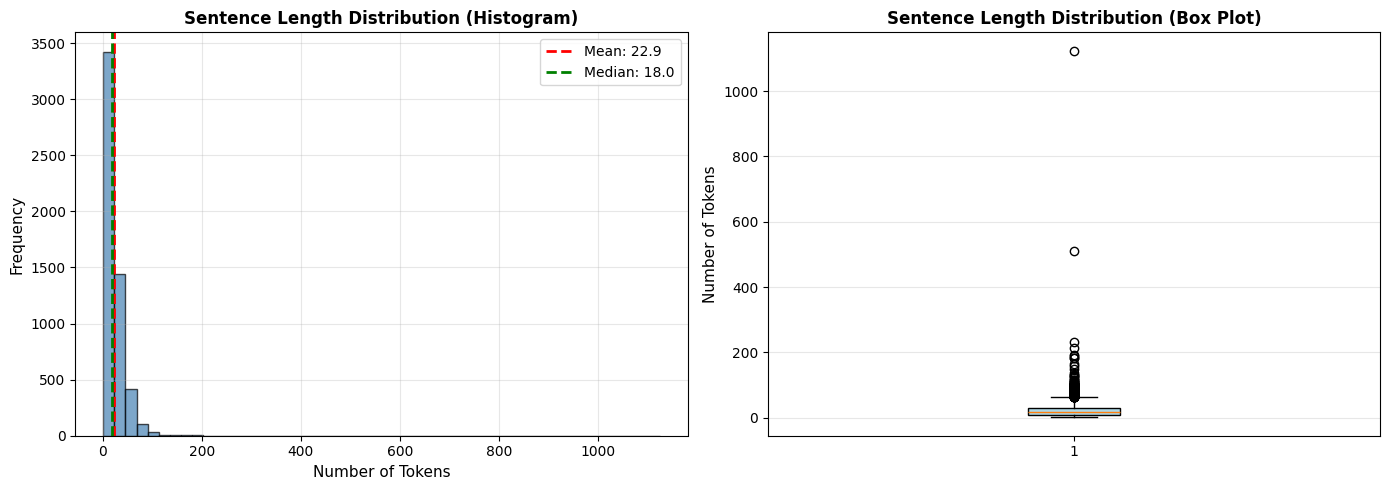

Sentence Length Statistics:
  Count:  5432
  Mean:   22.85
  Median: 18.00
  Std:    25.24
  Min:    1
  Max:    1124
  25th percentile: 9
  75th percentile: 30


In [58]:
# Speech length distribution
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram with statistics
ax1 = axes[0]
ax1.hist(final_df['sentence_length'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')

# Add statistical lines
mean_len = final_df['sentence_length'].mean()
median_len = final_df['sentence_length'].median()
ax1.axvline(mean_len, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_len:.1f}')
ax1.axvline(median_len, color='green', linestyle='--', linewidth=2, label=f'Median: {median_len:.1f}')

ax1.set_title('Sentence Length Distribution (Histogram)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Number of Tokens', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.legend()
ax1.grid(alpha=0.3)

# Box plot
ax2 = axes[1]
bp = ax2.boxplot(final_df['sentence_length'], vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
ax2.set_title('Sentence Length Distribution (Box Plot)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Tokens', fontsize=11)
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Sentence Length Statistics:")
print(f"  Count:  {len(final_df)}")
print(f"  Mean:   {mean_len:.2f}")
print(f"  Median: {median_len:.2f}")
print(f"  Std:    {final_df['sentence_length'].std():.2f}")
print(f"  Min:    {final_df['sentence_length'].min()}")
print(f"  Max:    {final_df['sentence_length'].max()}")
print(f"  25th percentile: {final_df['sentence_length'].quantile(0.25):.0f}")
print(f"  75th percentile: {final_df['sentence_length'].quantile(0.75):.0f}")

In [59]:
# Data range inspection for each country
countries = final_df['country_code'].unique()
for country in countries:
    country_data = final_df[final_df['country_code'] == country]
    min_date = country_data['date'].min()
    max_date = country_data['date'].max()
    print(f"Country: {country}, Date Range: {min_date.date()} to {max_date.date()}")

Country: SE, Date Range: 2017-12-12 to 2022-05-13
Country: UA, Date Range: 2008-09-30 to 2023-11-09
Country: PL, Date Range: 2017-07-20 to 2022-06-23
Country: BE, Date Range: 2017-04-27 to 2022-07-13
Country: GR, Date Range: 2017-06-09 to 2022-02-01
Country: NO, Date Range: 2004-06-08 to 2022-05-10
Country: EE, Date Range: 2014-12-02 to 2022-06-17
Country: LV, Date Range: 2019-01-31 to 2022-10-13
Country: CZ, Date Range: 2016-10-27 to 2023-07-26
Country: IS, Date Range: 2017-03-20 to 2022-06-15
Country: IT, Date Range: 2015-06-10 to 2022-09-07
Country: RS, Date Range: 2008-07-18 to 2022-02-14
Country: SI, Date Range: 2007-11-28 to 2022-04-06
Country: PT, Date Range: 2017-11-29 to 2024-02-07
Country: ES-GA, Date Range: 2017-05-24 to 2022-05-24
Country: GB, Date Range: 2017-09-07 to 2022-07-21
Country: BA, Date Range: 2006-07-07 to 2022-06-30
Country: ES-PV, Date Range: 2017-10-05 to 2022-10-14
Country: AT, Date Range: 2005-04-27 to 2022-10-12
Country: DK, Date Range: 2017-05-18 to 2022-

In [62]:
# Speaker and organization per country
countries = final_df['country_code'].unique()
for country in countries:
    country_data = final_df[final_df['country_code'] == country]
    speakers = country_data['speaker'].unique()
    parties = country_data['party_id'].unique()
    print(f"Country: {country}, Unique Speakers: {len(speakers)}, Unique Parties: {len(parties)}")

Country: SE, Unique Speakers: 12, Unique Parties: 2
Country: UA, Unique Speakers: 10, Unique Parties: 1
Country: PL, Unique Speakers: 10, Unique Parties: 2
Country: BE, Unique Speakers: 10, Unique Parties: 8
Country: GR, Unique Speakers: 6, Unique Parties: 3
Country: NO, Unique Speakers: 6, Unique Parties: 4
Country: EE, Unique Speakers: 7, Unique Parties: 5
Country: LV, Unique Speakers: 8, Unique Parties: 6
Country: CZ, Unique Speakers: 12, Unique Parties: 11
Country: IS, Unique Speakers: 9, Unique Parties: 4
Country: IT, Unique Speakers: 7, Unique Parties: 1
Country: RS, Unique Speakers: 9, Unique Parties: 7
Country: SI, Unique Speakers: 9, Unique Parties: 2
Country: PT, Unique Speakers: 9, Unique Parties: 4
Country: ES-GA, Unique Speakers: 4, Unique Parties: 1
Country: GB, Unique Speakers: 11, Unique Parties: 4
Country: BA, Unique Speakers: 7, Unique Parties: 6
Country: ES-PV, Unique Speakers: 4, Unique Parties: 3
Country: AT, Unique Speakers: 4, Unique Parties: 1
Country: DK, Uniqu

## Gouvernment vs Opposition